## Setting up
- Notebook: `SGD(model.parameters(), lr=0.01, momentum=0.9)` 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/"My Drive"/"Data Colab"/oml-project

/content/drive/My Drive/Data Colab/oml-project


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# hyperparameters
BATCH_SIZE = 64

In [ ]:
train_set = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [ ]:
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])) 

Files already downloaded and verified


In [ ]:
# sampling for smaller dataset: train
TRAIN_SAMPLES = int(len(train_set) / (10 * 2))
train_class_seen = dict([(i, 0) for i in range(10)])
train_indices = []
for i, (_, l) in enumerate(train_set):
  if train_class_seen[l] >= TRAIN_SAMPLES:
    continue
  train_class_seen[l] += 1
  train_indices.append(i)
train_subset = torch.utils.data.Subset(train_set, train_indices)
len(train_subset)

25000

In [ ]:
# sampling for smaller dataset: test
TEST_SAMPLES = int(len(test_set) / (10 * 3))
test_class_seen = dict([(i, 0) for i in range(10)])
test_indices = []
for i, (_, l) in enumerate(test_set):
  if test_class_seen[l] >= TEST_SAMPLES:
    continue
  test_class_seen[l] += 1
  test_indices.append(i)
test_subset = torch.utils.data.Subset(test_set, test_indices)
# store the test set as a single tensor
test_X, test_Y = [], []
for s, l in test_subset:
  test_X.append(s)
  test_Y.append(l)
test_X = torch.stack(test_X).float()
test_Y = torch.tensor(test_Y).long()
test_X, test_Y = test_X.to(device), test_Y.to(device)
test_X.shape, test_Y.shape

(torch.Size([3330, 3, 32, 32]), torch.Size([3330]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Analysis

In [ ]:
sample_image, sample_label = train_set[100]

In [ ]:
sample_image.shape

torch.Size([3, 32, 32])

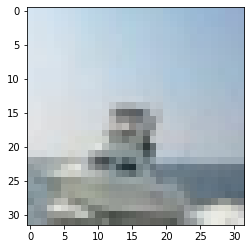

In [ ]:
plt.imshow(np.transpose(sample_image.numpy(), (1, 2, 0)))
plt.show()

In [ ]:
len(train_set), len(test_set)

(50000, 10000)

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
    )
    self.lin = nn.Sequential(
        nn.Linear(in_features=32*15*15, out_features=600),
        nn.ReLU(),
        nn.Linear(in_features=600, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=10)
    )
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.lin(out)
    out = self.softmax(out)
    return out
model = CNN()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (lin): Sequential(
    (0): Linear(in_features=7200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# hyperparameters
NUM_EPOCHS = 100

In [ ]:
error = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 63.57it/s]


Performace at epoch 1
Train Loss: 1.97611 ; Train Acc: 0.27656
Test Loss: 1.72530 ; Test Acc: 0.37357


100%|██████████| 391/391 [00:05<00:00, 66.28it/s]


Performace at epoch 2
Train Loss: 1.55464 ; Train Acc: 0.43464
Test Loss: 1.50659 ; Test Acc: 0.46577


100%|██████████| 391/391 [00:05<00:00, 68.32it/s]


Performace at epoch 3
Train Loss: 1.35498 ; Train Acc: 0.51248
Test Loss: 1.26708 ; Test Acc: 0.53243


100%|██████████| 391/391 [00:05<00:00, 67.86it/s]


Performace at epoch 4
Train Loss: 1.21281 ; Train Acc: 0.56752
Test Loss: 1.24241 ; Test Acc: 0.54775


100%|██████████| 391/391 [00:05<00:00, 67.26it/s]


Performace at epoch 5
Train Loss: 1.09477 ; Train Acc: 0.60928
Test Loss: 1.19366 ; Test Acc: 0.57868


100%|██████████| 391/391 [00:05<00:00, 67.56it/s]


Performace at epoch 6
Train Loss: 0.96429 ; Train Acc: 0.65792
Test Loss: 1.15520 ; Test Acc: 0.58619


100%|██████████| 391/391 [00:05<00:00, 66.63it/s]


Performace at epoch 7
Train Loss: 0.83036 ; Train Acc: 0.70396
Test Loss: 1.12127 ; Test Acc: 0.60751


100%|██████████| 391/391 [00:05<00:00, 67.28it/s]


Performace at epoch 8
Train Loss: 0.68571 ; Train Acc: 0.75916
Test Loss: 1.21627 ; Test Acc: 0.60000


100%|██████████| 391/391 [00:05<00:00, 67.46it/s]


Performace at epoch 9
Train Loss: 0.54282 ; Train Acc: 0.80980
Test Loss: 1.27248 ; Test Acc: 0.60511


100%|██████████| 391/391 [00:05<00:00, 67.11it/s]


Performace at epoch 10
Train Loss: 0.40710 ; Train Acc: 0.86008
Test Loss: 1.34990 ; Test Acc: 0.62132


100%|██████████| 391/391 [00:05<00:00, 67.10it/s]


Performace at epoch 11
Train Loss: 0.29337 ; Train Acc: 0.89880
Test Loss: 1.53799 ; Test Acc: 0.59790


100%|██████████| 391/391 [00:05<00:00, 67.31it/s]


Performace at epoch 12
Train Loss: 0.21022 ; Train Acc: 0.92980
Test Loss: 1.70991 ; Test Acc: 0.58499


100%|██████████| 391/391 [00:05<00:00, 67.32it/s]


Performace at epoch 13
Train Loss: 0.15487 ; Train Acc: 0.94908
Test Loss: 1.79691 ; Test Acc: 0.61441


100%|██████████| 391/391 [00:05<00:00, 68.32it/s]


Performace at epoch 14
Train Loss: 0.10523 ; Train Acc: 0.96560
Test Loss: 1.94083 ; Test Acc: 0.60901


100%|██████████| 391/391 [00:05<00:00, 65.92it/s]


Performace at epoch 15
Train Loss: 0.09275 ; Train Acc: 0.97080
Test Loss: 2.12466 ; Test Acc: 0.60511


100%|██████████| 391/391 [00:05<00:00, 67.78it/s]


Performace at epoch 16
Train Loss: 0.07280 ; Train Acc: 0.97716
Test Loss: 2.23617 ; Test Acc: 0.60601


100%|██████████| 391/391 [00:05<00:00, 66.66it/s]


Performace at epoch 17
Train Loss: 0.07609 ; Train Acc: 0.97492
Test Loss: 2.30314 ; Test Acc: 0.62132


100%|██████████| 391/391 [00:05<00:00, 66.63it/s]


Performace at epoch 18
Train Loss: 0.05565 ; Train Acc: 0.98300
Test Loss: 2.38981 ; Test Acc: 0.61682


100%|██████████| 391/391 [00:05<00:00, 66.16it/s]


Performace at epoch 19
Train Loss: 0.02853 ; Train Acc: 0.99200
Test Loss: 2.50196 ; Test Acc: 0.60480


100%|██████████| 391/391 [00:05<00:00, 65.90it/s]


Performace at epoch 20
Train Loss: 0.01251 ; Train Acc: 0.99732
Test Loss: 2.62380 ; Test Acc: 0.62312


100%|██████████| 391/391 [00:05<00:00, 66.08it/s]


Performace at epoch 21
Train Loss: 0.00781 ; Train Acc: 0.99840
Test Loss: 2.55204 ; Test Acc: 0.62853


100%|██████████| 391/391 [00:05<00:00, 66.01it/s]


Performace at epoch 22
Train Loss: 0.00349 ; Train Acc: 0.99932
Test Loss: 2.62363 ; Test Acc: 0.63033


100%|██████████| 391/391 [00:05<00:00, 66.19it/s]


Performace at epoch 23
Train Loss: 0.00155 ; Train Acc: 0.99984
Test Loss: 2.63819 ; Test Acc: 0.62943


100%|██████████| 391/391 [00:05<00:00, 65.31it/s]


Performace at epoch 24
Train Loss: 0.00099 ; Train Acc: 0.99984
Test Loss: 2.69110 ; Test Acc: 0.63123


100%|██████████| 391/391 [00:05<00:00, 65.98it/s]


Performace at epoch 25
Train Loss: 0.00112 ; Train Acc: 0.99976
Test Loss: 2.71727 ; Test Acc: 0.63183


100%|██████████| 391/391 [00:05<00:00, 66.68it/s]


Performace at epoch 26
Train Loss: 0.00066 ; Train Acc: 0.99996
Test Loss: 2.74513 ; Test Acc: 0.63183


100%|██████████| 391/391 [00:05<00:00, 66.27it/s]


Performace at epoch 27
Train Loss: 0.00059 ; Train Acc: 0.99996
Test Loss: 2.79323 ; Test Acc: 0.63393


100%|██████████| 391/391 [00:05<00:00, 66.40it/s]


Performace at epoch 28
Train Loss: 0.00051 ; Train Acc: 0.99992
Test Loss: 2.79205 ; Test Acc: 0.63483


100%|██████████| 391/391 [00:05<00:00, 66.29it/s]


Performace at epoch 29
Train Loss: 0.00043 ; Train Acc: 0.99992
Test Loss: 2.80853 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:05<00:00, 66.54it/s]


Performace at epoch 30
Train Loss: 0.00030 ; Train Acc: 1.00000
Test Loss: 2.83415 ; Test Acc: 0.63393


100%|██████████| 391/391 [00:05<00:00, 66.12it/s]


Performace at epoch 31
Train Loss: 0.00027 ; Train Acc: 1.00000
Test Loss: 2.84447 ; Test Acc: 0.63664


100%|██████████| 391/391 [00:05<00:00, 66.75it/s]


Performace at epoch 32
Train Loss: 0.00025 ; Train Acc: 1.00000
Test Loss: 2.86586 ; Test Acc: 0.63634


100%|██████████| 391/391 [00:05<00:00, 66.06it/s]


Performace at epoch 33
Train Loss: 0.00023 ; Train Acc: 1.00000
Test Loss: 2.87618 ; Test Acc: 0.63574


100%|██████████| 391/391 [00:05<00:00, 66.42it/s]


Performace at epoch 34
Train Loss: 0.00021 ; Train Acc: 1.00000
Test Loss: 2.89519 ; Test Acc: 0.63634


100%|██████████| 391/391 [00:05<00:00, 66.40it/s]


Performace at epoch 35
Train Loss: 0.00020 ; Train Acc: 1.00000
Test Loss: 2.90462 ; Test Acc: 0.63724


100%|██████████| 391/391 [00:05<00:00, 65.94it/s]


Performace at epoch 36
Train Loss: 0.00019 ; Train Acc: 1.00000
Test Loss: 2.91852 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 66.69it/s]


Performace at epoch 37
Train Loss: 0.00018 ; Train Acc: 1.00000
Test Loss: 2.92460 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 65.17it/s]


Performace at epoch 38
Train Loss: 0.00017 ; Train Acc: 1.00000
Test Loss: 2.93495 ; Test Acc: 0.63724


100%|██████████| 391/391 [00:05<00:00, 65.55it/s]


Performace at epoch 39
Train Loss: 0.00016 ; Train Acc: 1.00000
Test Loss: 2.94889 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 65.12it/s]


Performace at epoch 40
Train Loss: 0.00016 ; Train Acc: 1.00000
Test Loss: 2.95589 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:05<00:00, 65.92it/s]


Performace at epoch 41
Train Loss: 0.00015 ; Train Acc: 1.00000
Test Loss: 2.96622 ; Test Acc: 0.63754


100%|██████████| 391/391 [00:05<00:00, 65.33it/s]


Performace at epoch 42
Train Loss: 0.00014 ; Train Acc: 1.00000
Test Loss: 2.97535 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.56it/s]


Performace at epoch 43
Train Loss: 0.00014 ; Train Acc: 1.00000
Test Loss: 2.98186 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.82it/s]


Performace at epoch 44
Train Loss: 0.00013 ; Train Acc: 1.00000
Test Loss: 2.99399 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.77it/s]


Performace at epoch 45
Train Loss: 0.00013 ; Train Acc: 1.00000
Test Loss: 3.00344 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.22it/s]


Performace at epoch 46
Train Loss: 0.00012 ; Train Acc: 1.00000
Test Loss: 3.00897 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:06<00:00, 64.96it/s]


Performace at epoch 47
Train Loss: 0.00012 ; Train Acc: 1.00000
Test Loss: 3.01442 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:05<00:00, 65.59it/s]


Performace at epoch 48
Train Loss: 0.00012 ; Train Acc: 1.00000
Test Loss: 3.02197 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.46it/s]


Performace at epoch 49
Train Loss: 0.00011 ; Train Acc: 1.00000
Test Loss: 3.02994 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:05<00:00, 65.47it/s]


Performace at epoch 50
Train Loss: 0.00011 ; Train Acc: 1.00000
Test Loss: 3.03740 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 64.81it/s]


Performace at epoch 51
Train Loss: 0.00011 ; Train Acc: 1.00000
Test Loss: 3.04266 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:06<00:00, 64.72it/s]


Performace at epoch 52
Train Loss: 0.00010 ; Train Acc: 1.00000
Test Loss: 3.04992 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:06<00:00, 64.60it/s]


Performace at epoch 53
Train Loss: 0.00010 ; Train Acc: 1.00000
Test Loss: 3.05427 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 65.06it/s]


Performace at epoch 54
Train Loss: 0.00010 ; Train Acc: 1.00000
Test Loss: 3.05740 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.25it/s]


Performace at epoch 55
Train Loss: 0.00010 ; Train Acc: 1.00000
Test Loss: 3.06685 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 64.83it/s]


Performace at epoch 56
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.07223 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.39it/s]


Performace at epoch 57
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.07771 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 64.89it/s]


Performace at epoch 58
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.08172 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.86it/s]


Performace at epoch 59
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.08831 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 65.02it/s]


Performace at epoch 60
Train Loss: 0.00009 ; Train Acc: 1.00000
Test Loss: 3.09242 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.41it/s]


Performace at epoch 61
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.09526 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:06<00:00, 64.68it/s]


Performace at epoch 62
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.10458 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:06<00:00, 65.13it/s]


Performace at epoch 63
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.10705 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.26it/s]


Performace at epoch 64
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.11285 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 64.91it/s]


Performace at epoch 65
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.11850 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:06<00:00, 65.06it/s]


Performace at epoch 66
Train Loss: 0.00008 ; Train Acc: 1.00000
Test Loss: 3.12001 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:05<00:00, 65.48it/s]


Performace at epoch 67
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.12684 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:06<00:00, 64.86it/s]


Performace at epoch 68
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.12787 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.58it/s]


Performace at epoch 69
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.13505 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.46it/s]


Performace at epoch 70
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.13974 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:06<00:00, 64.08it/s]


Performace at epoch 71
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.14114 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 63.64it/s]


Performace at epoch 72
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.14852 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:06<00:00, 65.04it/s]


Performace at epoch 73
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.15041 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.19it/s]


Performace at epoch 74
Train Loss: 0.00007 ; Train Acc: 1.00000
Test Loss: 3.15533 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.48it/s]


Performace at epoch 75
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.16015 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.23it/s]


Performace at epoch 76
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.16170 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 66.15it/s]


Performace at epoch 77
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.16623 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.48it/s]


Performace at epoch 78
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.16907 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:06<00:00, 64.84it/s]


Performace at epoch 79
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.17394 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:06<00:00, 65.07it/s]


Performace at epoch 80
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.17712 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:06<00:00, 64.61it/s]


Performace at epoch 81
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.17971 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 65.21it/s]


Performace at epoch 82
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.18576 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 65.34it/s]


Performace at epoch 83
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.18703 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.29it/s]


Performace at epoch 84
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.18845 ; Test Acc: 0.63964


100%|██████████| 391/391 [00:05<00:00, 66.00it/s]


Performace at epoch 85
Train Loss: 0.00006 ; Train Acc: 1.00000
Test Loss: 3.19448 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:06<00:00, 65.12it/s]


Performace at epoch 86
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.19882 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 66.51it/s]


Performace at epoch 87
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.20051 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 66.26it/s]


Performace at epoch 88
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.20291 ; Test Acc: 0.63934


100%|██████████| 391/391 [00:05<00:00, 65.96it/s]


Performace at epoch 89
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.20761 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.38it/s]


Performace at epoch 90
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.20993 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.86it/s]


Performace at epoch 91
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.21323 ; Test Acc: 0.63814


100%|██████████| 391/391 [00:05<00:00, 66.10it/s]


Performace at epoch 92
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.21635 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.64it/s]


Performace at epoch 93
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.21819 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 66.55it/s]


Performace at epoch 94
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.22179 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.29it/s]


Performace at epoch 95
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.22532 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.48it/s]


Performace at epoch 96
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.22673 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 66.10it/s]


Performace at epoch 97
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.22916 ; Test Acc: 0.63904


100%|██████████| 391/391 [00:05<00:00, 65.77it/s]


Performace at epoch 98
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.23316 ; Test Acc: 0.63874


100%|██████████| 391/391 [00:05<00:00, 65.85it/s]


Performace at epoch 99
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.23562 ; Test Acc: 0.63844


100%|██████████| 391/391 [00:05<00:00, 65.45it/s]


Performace at epoch 100
Train Loss: 0.00005 ; Train Acc: 1.00000
Test Loss: 3.23821 ; Test Acc: 0.63904


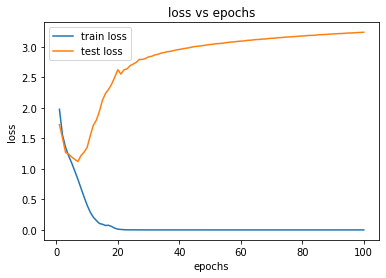

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

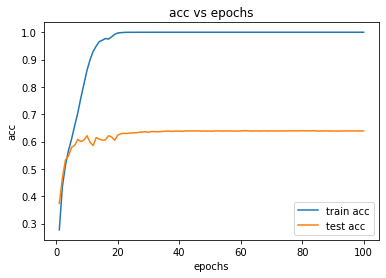

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()

## Hyperparameter tuning
- For a set of hyperparameters, various trials with different models are trained based on randomly-sampled or exhaustive hyperparameters upto a certain number of epochs (dependent on lr). Finally the best set of hyperparameters are chosen which correspond to the minimum testing loss after training.

In [ ]:
import decimal

In [ ]:
HYPERPARAMS = {
    'lr': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001],
    'momentum': [0.3, 0.5, 0.7, 0.9, 0.99]
}
TRIALS = 10

def get_epochs(lr):
    '''
    returns number of epochs for a given learning rate while tuning
    '''
    d = decimal.Decimal(str(lr))
    pow = d.as_tuple().exponent
    if pow >= -1:
        return 10
    elif pow >= -2:
        return 15
    elif pow >= -3:
        return 20
    else:
        return 25

In [ ]:
best_params, min_loss = None, np.inf
for t in range(TRIALS):
    print(f'\n> Starting trial {t+1}')
    ## choose a set of hyperparameters
    chosen = {}
    for h in HYPERPARAMS:
        chosen[h] = np.random.choice(HYPERPARAMS[h])
    print(f'Chosen hyperparams: {chosen}')
    print()
    ## model, loss & optimizer
    model = CNN()
    model.to(device)
    error = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=chosen['lr'], momentum=chosen['momentum'])
    ## training
    EPOCHS_TEST = get_epochs(chosen['lr'])
    for epoch in range(1, EPOCHS_TEST + 1):
        total_loss = 0; total = 0
        for images, labels in tqdm(train_loader):
            # forward + backward + step
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = error(outputs, labels)
            total_loss += loss.item() * len(outputs)
            loss.backward() 
            optimizer.step() 
            total += len(labels)
        total_loss /= total
        print(f'Training loss at epoch {epoch}: {total_loss:.5f}')
    ## calculate testing loss
    with torch.no_grad():
        predicted = model(test_X)
        testing_loss = error(predicted, test_Y).item()
    print(f'* Testing loss: {testing_loss:.5f}')
    ## check final total loss
    if testing_loss < min_loss:
        min_loss = testing_loss
        best_params = chosen
        print()
        print(f'* Best params updated!: {best_params}')
    print('==============')


> Starting trial 1
Chosen hyperparams: {'lr': 0.001, 'momentum': 0.7}



100%|██████████| 391/391 [00:05<00:00, 65.41it/s]


Training loss at epoch 1: 2.28894


100%|██████████| 391/391 [00:05<00:00, 66.78it/s]


Training loss at epoch 2: 2.25107


100%|██████████| 391/391 [00:05<00:00, 66.20it/s]


Training loss at epoch 3: 2.17846


100%|██████████| 391/391 [00:05<00:00, 67.20it/s]


Training loss at epoch 4: 2.08043


100%|██████████| 391/391 [00:05<00:00, 67.85it/s]


Training loss at epoch 5: 2.00700


100%|██████████| 391/391 [00:05<00:00, 67.20it/s]


Training loss at epoch 6: 1.96277


100%|██████████| 391/391 [00:05<00:00, 67.64it/s]


Training loss at epoch 7: 1.93097


100%|██████████| 391/391 [00:05<00:00, 66.85it/s]


Training loss at epoch 8: 1.90675


100%|██████████| 391/391 [00:05<00:00, 67.01it/s]


Training loss at epoch 9: 1.88533


100%|██████████| 391/391 [00:05<00:00, 66.85it/s]


Training loss at epoch 10: 1.86374


100%|██████████| 391/391 [00:05<00:00, 67.96it/s]


Training loss at epoch 11: 1.84377


100%|██████████| 391/391 [00:05<00:00, 66.44it/s]


Training loss at epoch 12: 1.82142


100%|██████████| 391/391 [00:05<00:00, 67.39it/s]


Training loss at epoch 13: 1.79995


100%|██████████| 391/391 [00:05<00:00, 67.87it/s]


Training loss at epoch 14: 1.77583


100%|██████████| 391/391 [00:05<00:00, 65.85it/s]


Training loss at epoch 15: 1.74845


100%|██████████| 391/391 [00:05<00:00, 65.77it/s]


Training loss at epoch 16: 1.72001


100%|██████████| 391/391 [00:05<00:00, 67.07it/s]


Training loss at epoch 17: 1.69234


100%|██████████| 391/391 [00:05<00:00, 66.22it/s]


Training loss at epoch 18: 1.66521


100%|██████████| 391/391 [00:05<00:00, 67.13it/s]


Training loss at epoch 19: 1.63795


100%|██████████| 391/391 [00:05<00:00, 66.24it/s]


Training loss at epoch 20: 1.61320
* Testing loss: 1.60276

* Best params updated!: {'lr': 0.001, 'momentum': 0.7}

> Starting trial 2
Chosen hyperparams: {'lr': 0.0001, 'momentum': 0.9}



100%|██████████| 391/391 [00:05<00:00, 66.74it/s]


Training loss at epoch 1: 2.30153


100%|██████████| 391/391 [00:05<00:00, 66.34it/s]


Training loss at epoch 2: 2.29619


100%|██████████| 391/391 [00:05<00:00, 66.59it/s]


Training loss at epoch 3: 2.29146


100%|██████████| 391/391 [00:05<00:00, 67.94it/s]


Training loss at epoch 4: 2.28623


100%|██████████| 391/391 [00:05<00:00, 67.91it/s]


Training loss at epoch 5: 2.27985


100%|██████████| 391/391 [00:05<00:00, 67.86it/s]


Training loss at epoch 6: 2.27211


100%|██████████| 391/391 [00:05<00:00, 67.31it/s]


Training loss at epoch 7: 2.26254


100%|██████████| 391/391 [00:05<00:00, 66.78it/s]


Training loss at epoch 8: 2.25038


100%|██████████| 391/391 [00:05<00:00, 67.41it/s]


Training loss at epoch 9: 2.23486


100%|██████████| 391/391 [00:05<00:00, 67.29it/s]


Training loss at epoch 10: 2.21509


100%|██████████| 391/391 [00:05<00:00, 66.28it/s]


Training loss at epoch 11: 2.19097


100%|██████████| 391/391 [00:05<00:00, 67.46it/s]


Training loss at epoch 12: 2.16324


100%|██████████| 391/391 [00:05<00:00, 66.11it/s]


Training loss at epoch 13: 2.13415


100%|██████████| 391/391 [00:05<00:00, 66.64it/s]


Training loss at epoch 14: 2.10590


100%|██████████| 391/391 [00:05<00:00, 66.39it/s]


Training loss at epoch 15: 2.07944


100%|██████████| 391/391 [00:05<00:00, 66.76it/s]


Training loss at epoch 16: 2.05517


100%|██████████| 391/391 [00:05<00:00, 66.76it/s]


Training loss at epoch 17: 2.03328


100%|██████████| 391/391 [00:05<00:00, 65.71it/s]


Training loss at epoch 18: 2.01331


100%|██████████| 391/391 [00:05<00:00, 67.02it/s]


Training loss at epoch 19: 1.99543


100%|██████████| 391/391 [00:05<00:00, 66.50it/s]


Training loss at epoch 20: 1.97917


100%|██████████| 391/391 [00:05<00:00, 66.46it/s]


Training loss at epoch 21: 1.96488


100%|██████████| 391/391 [00:05<00:00, 66.17it/s]


Training loss at epoch 22: 1.95218


100%|██████████| 391/391 [00:05<00:00, 66.37it/s]


Training loss at epoch 23: 1.94082


100%|██████████| 391/391 [00:05<00:00, 66.06it/s]


Training loss at epoch 24: 1.93051


100%|██████████| 391/391 [00:05<00:00, 65.80it/s]


Training loss at epoch 25: 1.92098
* Testing loss: 1.92154

> Starting trial 3
Chosen hyperparams: {'lr': 0.05, 'momentum': 0.9}



100%|██████████| 391/391 [00:05<00:00, 65.96it/s]


Training loss at epoch 1: 1.89588


100%|██████████| 391/391 [00:05<00:00, 66.60it/s]


Training loss at epoch 2: 1.54870


100%|██████████| 391/391 [00:05<00:00, 66.30it/s]


Training loss at epoch 3: 1.34797


100%|██████████| 391/391 [00:05<00:00, 66.18it/s]


Training loss at epoch 4: 1.23792


100%|██████████| 391/391 [00:05<00:00, 66.20it/s]


Training loss at epoch 5: 1.08998


100%|██████████| 391/391 [00:05<00:00, 66.10it/s]


Training loss at epoch 6: 0.94577


100%|██████████| 391/391 [00:05<00:00, 66.05it/s]


Training loss at epoch 7: 0.80325


100%|██████████| 391/391 [00:05<00:00, 65.76it/s]


Training loss at epoch 8: 0.71801


100%|██████████| 391/391 [00:05<00:00, 65.77it/s]


Training loss at epoch 9: 0.56337


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Training loss at epoch 10: 0.51489


100%|██████████| 391/391 [00:05<00:00, 66.43it/s]


Training loss at epoch 11: 0.45544


100%|██████████| 391/391 [00:05<00:00, 66.07it/s]


Training loss at epoch 12: 0.40903


100%|██████████| 391/391 [00:06<00:00, 65.05it/s]


Training loss at epoch 13: 0.36451


100%|██████████| 391/391 [00:05<00:00, 65.20it/s]


Training loss at epoch 14: 0.33904


100%|██████████| 391/391 [00:05<00:00, 65.18it/s]


Training loss at epoch 15: 0.29772
* Testing loss: 2.77653

> Starting trial 4
Chosen hyperparams: {'lr': 0.0001, 'momentum': 0.9}



100%|██████████| 391/391 [00:05<00:00, 65.61it/s]


Training loss at epoch 1: 2.30154


100%|██████████| 391/391 [00:06<00:00, 65.01it/s]


Training loss at epoch 2: 2.29523


100%|██████████| 391/391 [00:06<00:00, 65.07it/s]


Training loss at epoch 3: 2.28966


100%|██████████| 391/391 [00:06<00:00, 65.16it/s]


Training loss at epoch 4: 2.28360


100%|██████████| 391/391 [00:05<00:00, 65.82it/s]


Training loss at epoch 5: 2.27658


100%|██████████| 391/391 [00:06<00:00, 64.41it/s]


Training loss at epoch 6: 2.26833


100%|██████████| 391/391 [00:05<00:00, 65.36it/s]


Training loss at epoch 7: 2.25793


100%|██████████| 391/391 [00:06<00:00, 64.30it/s]


Training loss at epoch 8: 2.24485


100%|██████████| 391/391 [00:05<00:00, 66.20it/s]


Training loss at epoch 9: 2.22840


100%|██████████| 391/391 [00:05<00:00, 65.95it/s]


Training loss at epoch 10: 2.20807


100%|██████████| 391/391 [00:05<00:00, 66.24it/s]


Training loss at epoch 11: 2.18473


100%|██████████| 391/391 [00:05<00:00, 66.11it/s]


Training loss at epoch 12: 2.15957


100%|██████████| 391/391 [00:05<00:00, 65.82it/s]


Training loss at epoch 13: 2.13427


100%|██████████| 391/391 [00:05<00:00, 66.29it/s]


Training loss at epoch 14: 2.10997


100%|██████████| 391/391 [00:06<00:00, 64.76it/s]


Training loss at epoch 15: 2.08694


100%|██████████| 391/391 [00:05<00:00, 65.83it/s]


Training loss at epoch 16: 2.06471


100%|██████████| 391/391 [00:05<00:00, 65.86it/s]


Training loss at epoch 17: 2.04320


100%|██████████| 391/391 [00:05<00:00, 65.72it/s]


Training loss at epoch 18: 2.02276


100%|██████████| 391/391 [00:05<00:00, 66.46it/s]


Training loss at epoch 19: 2.00410


100%|██████████| 391/391 [00:05<00:00, 65.49it/s]


Training loss at epoch 20: 1.98754


100%|██████████| 391/391 [00:05<00:00, 65.29it/s]


Training loss at epoch 21: 1.97278


100%|██████████| 391/391 [00:05<00:00, 65.61it/s]


Training loss at epoch 22: 1.96039


100%|██████████| 391/391 [00:05<00:00, 66.75it/s]


Training loss at epoch 23: 1.94916


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Training loss at epoch 24: 1.93915


100%|██████████| 391/391 [00:05<00:00, 66.74it/s]


Training loss at epoch 25: 1.92985
* Testing loss: 1.93097

> Starting trial 5
Chosen hyperparams: {'lr': 0.0001, 'momentum': 0.9}



100%|██████████| 391/391 [00:05<00:00, 66.48it/s]


Training loss at epoch 1: 2.30057


100%|██████████| 391/391 [00:05<00:00, 66.58it/s]


Training loss at epoch 2: 2.29476


100%|██████████| 391/391 [00:05<00:00, 65.89it/s]


Training loss at epoch 3: 2.28953


100%|██████████| 391/391 [00:05<00:00, 67.14it/s]


Training loss at epoch 4: 2.28390


100%|██████████| 391/391 [00:05<00:00, 67.02it/s]


Training loss at epoch 5: 2.27731


100%|██████████| 391/391 [00:05<00:00, 66.01it/s]


Training loss at epoch 6: 2.26926


100%|██████████| 391/391 [00:05<00:00, 66.18it/s]


Training loss at epoch 7: 2.25926


100%|██████████| 391/391 [00:06<00:00, 64.74it/s]


Training loss at epoch 8: 2.24644


100%|██████████| 391/391 [00:06<00:00, 64.99it/s]


Training loss at epoch 9: 2.22998


100%|██████████| 391/391 [00:05<00:00, 66.28it/s]


Training loss at epoch 10: 2.20911


100%|██████████| 391/391 [00:05<00:00, 67.25it/s]


Training loss at epoch 11: 2.18341


100%|██████████| 391/391 [00:05<00:00, 66.91it/s]


Training loss at epoch 12: 2.15338


100%|██████████| 391/391 [00:05<00:00, 67.28it/s]


Training loss at epoch 13: 2.12123


100%|██████████| 391/391 [00:05<00:00, 67.53it/s]


Training loss at epoch 14: 2.09074


100%|██████████| 391/391 [00:05<00:00, 66.63it/s]


Training loss at epoch 15: 2.06425


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Training loss at epoch 16: 2.04215


100%|██████████| 391/391 [00:05<00:00, 68.35it/s]


Training loss at epoch 17: 2.02395


100%|██████████| 391/391 [00:05<00:00, 66.55it/s]


Training loss at epoch 18: 2.00865


100%|██████████| 391/391 [00:05<00:00, 65.78it/s]


Training loss at epoch 19: 1.99531


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Training loss at epoch 20: 1.98299


100%|██████████| 391/391 [00:05<00:00, 66.62it/s]


Training loss at epoch 21: 1.97227


100%|██████████| 391/391 [00:05<00:00, 66.06it/s]


Training loss at epoch 22: 1.96164


100%|██████████| 391/391 [00:05<00:00, 65.37it/s]


Training loss at epoch 23: 1.95202


100%|██████████| 391/391 [00:05<00:00, 66.65it/s]


Training loss at epoch 24: 1.94198


100%|██████████| 391/391 [00:05<00:00, 65.38it/s]


Training loss at epoch 25: 1.93309
* Testing loss: 1.93740

> Starting trial 6
Chosen hyperparams: {'lr': 0.1, 'momentum': 0.7}



100%|██████████| 391/391 [00:05<00:00, 66.08it/s]


Training loss at epoch 1: 1.89762


100%|██████████| 391/391 [00:05<00:00, 65.89it/s]


Training loss at epoch 2: 1.45207


100%|██████████| 391/391 [00:05<00:00, 66.09it/s]


Training loss at epoch 3: 1.23756


100%|██████████| 391/391 [00:05<00:00, 66.20it/s]


Training loss at epoch 4: 1.06930


100%|██████████| 391/391 [00:06<00:00, 64.65it/s]


Training loss at epoch 5: 0.89744


100%|██████████| 391/391 [00:05<00:00, 66.01it/s]


Training loss at epoch 6: 0.71337


100%|██████████| 391/391 [00:05<00:00, 66.57it/s]


Training loss at epoch 7: 0.56002


100%|██████████| 391/391 [00:06<00:00, 65.11it/s]


Training loss at epoch 8: 0.43558


100%|██████████| 391/391 [00:05<00:00, 65.47it/s]


Training loss at epoch 9: 0.35180


100%|██████████| 391/391 [00:05<00:00, 65.18it/s]


Training loss at epoch 10: 0.26690
* Testing loss: 2.10127

> Starting trial 7
Chosen hyperparams: {'lr': 0.001, 'momentum': 0.9}



100%|██████████| 391/391 [00:05<00:00, 65.97it/s]


Training loss at epoch 1: 2.26492


100%|██████████| 391/391 [00:05<00:00, 65.45it/s]


Training loss at epoch 2: 2.09275


100%|██████████| 391/391 [00:06<00:00, 65.11it/s]


Training loss at epoch 3: 1.94584


100%|██████████| 391/391 [00:05<00:00, 65.58it/s]


Training loss at epoch 4: 1.87886


100%|██████████| 391/391 [00:06<00:00, 64.82it/s]


Training loss at epoch 5: 1.80918


100%|██████████| 391/391 [00:05<00:00, 65.91it/s]


Training loss at epoch 6: 1.74486


100%|██████████| 391/391 [00:06<00:00, 65.12it/s]


Training loss at epoch 7: 1.67231


100%|██████████| 391/391 [00:05<00:00, 65.90it/s]


Training loss at epoch 8: 1.61090


100%|██████████| 391/391 [00:05<00:00, 66.00it/s]


Training loss at epoch 9: 1.55943


100%|██████████| 391/391 [00:05<00:00, 65.76it/s]


Training loss at epoch 10: 1.50129


100%|██████████| 391/391 [00:05<00:00, 65.82it/s]


Training loss at epoch 11: 1.45969


100%|██████████| 391/391 [00:05<00:00, 65.42it/s]


Training loss at epoch 12: 1.41071


100%|██████████| 391/391 [00:05<00:00, 65.49it/s]


Training loss at epoch 13: 1.36503


100%|██████████| 391/391 [00:05<00:00, 65.33it/s]


Training loss at epoch 14: 1.32665


100%|██████████| 391/391 [00:05<00:00, 66.06it/s]


Training loss at epoch 15: 1.29513


100%|██████████| 391/391 [00:05<00:00, 65.87it/s]


Training loss at epoch 16: 1.25857


100%|██████████| 391/391 [00:05<00:00, 65.18it/s]


Training loss at epoch 17: 1.23500


100%|██████████| 391/391 [00:06<00:00, 65.10it/s]


Training loss at epoch 18: 1.20563


100%|██████████| 391/391 [00:06<00:00, 65.12it/s]


Training loss at epoch 19: 1.17676


100%|██████████| 391/391 [00:05<00:00, 65.80it/s]


Training loss at epoch 20: 1.15048
* Testing loss: 1.22004

* Best params updated!: {'lr': 0.001, 'momentum': 0.9}

> Starting trial 8
Chosen hyperparams: {'lr': 0.001, 'momentum': 0.7}



100%|██████████| 391/391 [00:05<00:00, 65.71it/s]


Training loss at epoch 1: 2.29130


100%|██████████| 391/391 [00:05<00:00, 65.19it/s]


Training loss at epoch 2: 2.26512


100%|██████████| 391/391 [00:05<00:00, 65.47it/s]


Training loss at epoch 3: 2.21600


100%|██████████| 391/391 [00:05<00:00, 66.28it/s]


Training loss at epoch 4: 2.13372


100%|██████████| 391/391 [00:05<00:00, 65.62it/s]


Training loss at epoch 5: 2.05013


100%|██████████| 391/391 [00:05<00:00, 66.24it/s]


Training loss at epoch 6: 1.99049


100%|██████████| 391/391 [00:05<00:00, 65.20it/s]


Training loss at epoch 7: 1.95118


100%|██████████| 391/391 [00:05<00:00, 65.83it/s]


Training loss at epoch 8: 1.92416


100%|██████████| 391/391 [00:06<00:00, 64.71it/s]


Training loss at epoch 9: 1.90192


100%|██████████| 391/391 [00:05<00:00, 65.53it/s]


Training loss at epoch 10: 1.88203


100%|██████████| 391/391 [00:05<00:00, 65.79it/s]


Training loss at epoch 11: 1.86235


100%|██████████| 391/391 [00:05<00:00, 65.85it/s]


Training loss at epoch 12: 1.84268


100%|██████████| 391/391 [00:05<00:00, 65.54it/s]


Training loss at epoch 13: 1.82114


100%|██████████| 391/391 [00:05<00:00, 65.24it/s]


Training loss at epoch 14: 1.79828


100%|██████████| 391/391 [00:05<00:00, 65.56it/s]


Training loss at epoch 15: 1.77459


100%|██████████| 391/391 [00:05<00:00, 66.06it/s]


Training loss at epoch 16: 1.75216


100%|██████████| 391/391 [00:05<00:00, 65.21it/s]


Training loss at epoch 17: 1.72745


100%|██████████| 391/391 [00:05<00:00, 65.67it/s]


Training loss at epoch 18: 1.70349


100%|██████████| 391/391 [00:06<00:00, 65.07it/s]


Training loss at epoch 19: 1.67953


100%|██████████| 391/391 [00:05<00:00, 66.42it/s]


Training loss at epoch 20: 1.65778
* Testing loss: 1.64070

> Starting trial 9
Chosen hyperparams: {'lr': 0.001, 'momentum': 0.7}



100%|██████████| 391/391 [00:05<00:00, 65.86it/s]


Training loss at epoch 1: 2.29263


100%|██████████| 391/391 [00:05<00:00, 66.60it/s]


Training loss at epoch 2: 2.26755


100%|██████████| 391/391 [00:05<00:00, 66.23it/s]


Training loss at epoch 3: 2.22112


100%|██████████| 391/391 [00:05<00:00, 65.48it/s]


Training loss at epoch 4: 2.14592


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Training loss at epoch 5: 2.07001


100%|██████████| 391/391 [00:05<00:00, 66.09it/s]


Training loss at epoch 6: 2.00663


100%|██████████| 391/391 [00:05<00:00, 66.08it/s]


Training loss at epoch 7: 1.96398


100%|██████████| 391/391 [00:05<00:00, 66.13it/s]


Training loss at epoch 8: 1.93079


100%|██████████| 391/391 [00:05<00:00, 67.18it/s]


Training loss at epoch 9: 1.90459


100%|██████████| 391/391 [00:05<00:00, 66.13it/s]


Training loss at epoch 10: 1.88072


100%|██████████| 391/391 [00:05<00:00, 66.28it/s]


Training loss at epoch 11: 1.86110


100%|██████████| 391/391 [00:05<00:00, 66.71it/s]


Training loss at epoch 12: 1.83720


100%|██████████| 391/391 [00:05<00:00, 66.53it/s]


Training loss at epoch 13: 1.81529


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Training loss at epoch 14: 1.78890


100%|██████████| 391/391 [00:05<00:00, 65.45it/s]


Training loss at epoch 15: 1.76385


100%|██████████| 391/391 [00:05<00:00, 65.60it/s]


Training loss at epoch 16: 1.73590


100%|██████████| 391/391 [00:05<00:00, 66.61it/s]


Training loss at epoch 17: 1.70982


100%|██████████| 391/391 [00:05<00:00, 66.37it/s]


Training loss at epoch 18: 1.68415


100%|██████████| 391/391 [00:05<00:00, 65.89it/s]


Training loss at epoch 19: 1.65952


100%|██████████| 391/391 [00:05<00:00, 66.61it/s]


Training loss at epoch 20: 1.63875
* Testing loss: 1.67611

> Starting trial 10
Chosen hyperparams: {'lr': 0.0001, 'momentum': 0.99}



100%|██████████| 391/391 [00:05<00:00, 65.73it/s]


Training loss at epoch 1: 2.28983


100%|██████████| 391/391 [00:05<00:00, 66.27it/s]


Training loss at epoch 2: 2.21911


100%|██████████| 391/391 [00:05<00:00, 65.22it/s]


Training loss at epoch 3: 2.08409


100%|██████████| 391/391 [00:05<00:00, 66.16it/s]


Training loss at epoch 4: 1.94989


100%|██████████| 391/391 [00:05<00:00, 65.79it/s]


Training loss at epoch 5: 1.88122


100%|██████████| 391/391 [00:05<00:00, 65.96it/s]


Training loss at epoch 6: 1.82952


100%|██████████| 391/391 [00:05<00:00, 67.41it/s]


Training loss at epoch 7: 1.76721


100%|██████████| 391/391 [00:05<00:00, 65.73it/s]


Training loss at epoch 8: 1.70410


100%|██████████| 391/391 [00:05<00:00, 66.70it/s]


Training loss at epoch 9: 1.63860


100%|██████████| 391/391 [00:05<00:00, 66.32it/s]


Training loss at epoch 10: 1.58599


100%|██████████| 391/391 [00:05<00:00, 65.87it/s]


Training loss at epoch 11: 1.54442


100%|██████████| 391/391 [00:06<00:00, 65.10it/s]


Training loss at epoch 12: 1.49596


100%|██████████| 391/391 [00:06<00:00, 64.93it/s]


Training loss at epoch 13: 1.45026


100%|██████████| 391/391 [00:05<00:00, 65.74it/s]


Training loss at epoch 14: 1.41016


100%|██████████| 391/391 [00:05<00:00, 65.50it/s]


Training loss at epoch 15: 1.38189


100%|██████████| 391/391 [00:05<00:00, 65.30it/s]


Training loss at epoch 16: 1.33615


100%|██████████| 391/391 [00:05<00:00, 66.08it/s]


Training loss at epoch 17: 1.29819


100%|██████████| 391/391 [00:06<00:00, 64.95it/s]


Training loss at epoch 18: 1.27911


100%|██████████| 391/391 [00:05<00:00, 65.66it/s]


Training loss at epoch 19: 1.24908


100%|██████████| 391/391 [00:05<00:00, 65.65it/s]


Training loss at epoch 20: 1.22120


100%|██████████| 391/391 [00:05<00:00, 66.09it/s]


Training loss at epoch 21: 1.19508


100%|██████████| 391/391 [00:05<00:00, 65.63it/s]


Training loss at epoch 22: 1.17442


100%|██████████| 391/391 [00:05<00:00, 65.29it/s]


Training loss at epoch 23: 1.14983


100%|██████████| 391/391 [00:05<00:00, 65.58it/s]


Training loss at epoch 24: 1.11535


100%|██████████| 391/391 [00:06<00:00, 64.67it/s]

Training loss at epoch 25: 1.09177
* Testing loss: 1.20475

* Best params updated!: {'lr': 0.0001, 'momentum': 0.99}


### Training with the best hyperparameters

In [ ]:
best_params

{'lr': 0.0001, 'momentum': 0.99}

In [ ]:
model = CNN()
model.to(device)
error = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params['lr'], momentum=best_params['momentum'])

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:05<00:00, 66.26it/s]


Performace at epoch 1
Train Loss: 2.28690 ; Train Acc: 0.14908
Test Loss: 2.26182 ; Test Acc: 0.15916


100%|██████████| 391/391 [00:05<00:00, 66.71it/s]


Performace at epoch 2
Train Loss: 2.19164 ; Train Acc: 0.22460
Test Loss: 2.10811 ; Test Acc: 0.25766


100%|██████████| 391/391 [00:05<00:00, 66.22it/s]


Performace at epoch 3
Train Loss: 2.02410 ; Train Acc: 0.27676
Test Loss: 1.96684 ; Test Acc: 0.30180


100%|██████████| 391/391 [00:05<00:00, 67.11it/s]


Performace at epoch 4
Train Loss: 1.92517 ; Train Acc: 0.31316
Test Loss: 1.90458 ; Test Acc: 0.33303


100%|██████████| 391/391 [00:05<00:00, 66.77it/s]


Performace at epoch 5
Train Loss: 1.87216 ; Train Acc: 0.33624
Test Loss: 1.85890 ; Test Acc: 0.34715


100%|██████████| 391/391 [00:05<00:00, 66.50it/s]


Performace at epoch 6
Train Loss: 1.81600 ; Train Acc: 0.35916
Test Loss: 1.79320 ; Test Acc: 0.36066


100%|██████████| 391/391 [00:05<00:00, 67.10it/s]


Performace at epoch 7
Train Loss: 1.75675 ; Train Acc: 0.37584
Test Loss: 1.74586 ; Test Acc: 0.38228


100%|██████████| 391/391 [00:05<00:00, 67.54it/s]


Performace at epoch 8
Train Loss: 1.69173 ; Train Acc: 0.39680
Test Loss: 1.65424 ; Test Acc: 0.41592


100%|██████████| 391/391 [00:05<00:00, 67.34it/s]


Performace at epoch 9
Train Loss: 1.62912 ; Train Acc: 0.41220
Test Loss: 1.63046 ; Test Acc: 0.42312


100%|██████████| 391/391 [00:05<00:00, 66.42it/s]


Performace at epoch 10
Train Loss: 1.58075 ; Train Acc: 0.42716
Test Loss: 1.55119 ; Test Acc: 0.44685


100%|██████████| 391/391 [00:05<00:00, 67.06it/s]


Performace at epoch 11
Train Loss: 1.52335 ; Train Acc: 0.44612
Test Loss: 1.51576 ; Test Acc: 0.44625


100%|██████████| 391/391 [00:05<00:00, 67.52it/s]


Performace at epoch 12
Train Loss: 1.48226 ; Train Acc: 0.46428
Test Loss: 1.45977 ; Test Acc: 0.48529


100%|██████████| 391/391 [00:05<00:00, 67.13it/s]


Performace at epoch 13
Train Loss: 1.44463 ; Train Acc: 0.47816
Test Loss: 1.47225 ; Test Acc: 0.46456


100%|██████████| 391/391 [00:05<00:00, 66.67it/s]


Performace at epoch 14
Train Loss: 1.40217 ; Train Acc: 0.49228
Test Loss: 1.42186 ; Test Acc: 0.49459


100%|██████████| 391/391 [00:05<00:00, 67.03it/s]


Performace at epoch 15
Train Loss: 1.36728 ; Train Acc: 0.50716
Test Loss: 1.36426 ; Test Acc: 0.50811


100%|██████████| 391/391 [00:05<00:00, 67.32it/s]


Performace at epoch 16
Train Loss: 1.34361 ; Train Acc: 0.51408
Test Loss: 1.33473 ; Test Acc: 0.52553


100%|██████████| 391/391 [00:05<00:00, 66.52it/s]


Performace at epoch 17
Train Loss: 1.28680 ; Train Acc: 0.53796
Test Loss: 1.32590 ; Test Acc: 0.52372


100%|██████████| 391/391 [00:05<00:00, 66.72it/s]


Performace at epoch 18
Train Loss: 1.28590 ; Train Acc: 0.53588
Test Loss: 1.33360 ; Test Acc: 0.51982


100%|██████████| 391/391 [00:05<00:00, 67.12it/s]


Performace at epoch 19
Train Loss: 1.23312 ; Train Acc: 0.55648
Test Loss: 1.27513 ; Test Acc: 0.54444


100%|██████████| 391/391 [00:05<00:00, 67.43it/s]


Performace at epoch 20
Train Loss: 1.20790 ; Train Acc: 0.56856
Test Loss: 1.27172 ; Test Acc: 0.54715


100%|██████████| 391/391 [00:05<00:00, 67.75it/s]


Performace at epoch 21
Train Loss: 1.18781 ; Train Acc: 0.57204
Test Loss: 1.25986 ; Test Acc: 0.54535


100%|██████████| 391/391 [00:05<00:00, 67.17it/s]


Performace at epoch 22
Train Loss: 1.19334 ; Train Acc: 0.57028
Test Loss: 1.25274 ; Test Acc: 0.54444


100%|██████████| 391/391 [00:05<00:00, 66.29it/s]


Performace at epoch 23
Train Loss: 1.14062 ; Train Acc: 0.59288
Test Loss: 1.22736 ; Test Acc: 0.56126


100%|██████████| 391/391 [00:05<00:00, 67.30it/s]


Performace at epoch 24
Train Loss: 1.12001 ; Train Acc: 0.60116
Test Loss: 1.21649 ; Test Acc: 0.56336


100%|██████████| 391/391 [00:05<00:00, 67.90it/s]


Performace at epoch 25
Train Loss: 1.09400 ; Train Acc: 0.60980
Test Loss: 1.22328 ; Test Acc: 0.55826


100%|██████████| 391/391 [00:05<00:00, 67.23it/s]


Performace at epoch 26
Train Loss: 1.08063 ; Train Acc: 0.61252
Test Loss: 1.20328 ; Test Acc: 0.56396


100%|██████████| 391/391 [00:05<00:00, 67.67it/s]


Performace at epoch 27
Train Loss: 1.05089 ; Train Acc: 0.62684
Test Loss: 1.19528 ; Test Acc: 0.57417


100%|██████████| 391/391 [00:05<00:00, 67.11it/s]


Performace at epoch 28
Train Loss: 1.03376 ; Train Acc: 0.62808
Test Loss: 1.16376 ; Test Acc: 0.58679


100%|██████████| 391/391 [00:05<00:00, 66.46it/s]


Performace at epoch 29
Train Loss: 1.01596 ; Train Acc: 0.63972
Test Loss: 1.17718 ; Test Acc: 0.58859


100%|██████████| 391/391 [00:05<00:00, 66.32it/s]


Performace at epoch 30
Train Loss: 0.98287 ; Train Acc: 0.65060
Test Loss: 1.17950 ; Test Acc: 0.57958


100%|██████████| 391/391 [00:05<00:00, 66.96it/s]


Performace at epoch 31
Train Loss: 0.94685 ; Train Acc: 0.66776
Test Loss: 1.13936 ; Test Acc: 0.59249


100%|██████████| 391/391 [00:05<00:00, 66.62it/s]


Performace at epoch 32
Train Loss: 0.92990 ; Train Acc: 0.67128
Test Loss: 1.13932 ; Test Acc: 0.60030


100%|██████████| 391/391 [00:05<00:00, 67.53it/s]


Performace at epoch 33
Train Loss: 0.91075 ; Train Acc: 0.67736
Test Loss: 1.14498 ; Test Acc: 0.59369


100%|██████████| 391/391 [00:05<00:00, 67.05it/s]


Performace at epoch 34
Train Loss: 0.88699 ; Train Acc: 0.68728
Test Loss: 1.13229 ; Test Acc: 0.60571


100%|██████████| 391/391 [00:05<00:00, 67.64it/s]


Performace at epoch 35
Train Loss: 0.84999 ; Train Acc: 0.70020
Test Loss: 1.14628 ; Test Acc: 0.59550


100%|██████████| 391/391 [00:05<00:00, 67.48it/s]


Performace at epoch 36
Train Loss: 0.82500 ; Train Acc: 0.71120
Test Loss: 1.12926 ; Test Acc: 0.60300


100%|██████████| 391/391 [00:05<00:00, 66.27it/s]


Performace at epoch 37
Train Loss: 0.78800 ; Train Acc: 0.72280
Test Loss: 1.12491 ; Test Acc: 0.60871


100%|██████████| 391/391 [00:05<00:00, 66.63it/s]


Performace at epoch 38
Train Loss: 0.76274 ; Train Acc: 0.73368
Test Loss: 1.12986 ; Test Acc: 0.60511


100%|██████████| 391/391 [00:05<00:00, 66.92it/s]


Performace at epoch 39
Train Loss: 0.73645 ; Train Acc: 0.74376
Test Loss: 1.13796 ; Test Acc: 0.61081


100%|██████████| 391/391 [00:05<00:00, 67.39it/s]


Performace at epoch 40
Train Loss: 0.70816 ; Train Acc: 0.75392
Test Loss: 1.14791 ; Test Acc: 0.60270


100%|██████████| 391/391 [00:05<00:00, 66.97it/s]


Performace at epoch 41
Train Loss: 0.67249 ; Train Acc: 0.76952
Test Loss: 1.15019 ; Test Acc: 0.60691


100%|██████████| 391/391 [00:05<00:00, 65.66it/s]


Performace at epoch 42
Train Loss: 0.65492 ; Train Acc: 0.77560
Test Loss: 1.15027 ; Test Acc: 0.61471


100%|██████████| 391/391 [00:05<00:00, 66.22it/s]


Performace at epoch 43
Train Loss: 0.62416 ; Train Acc: 0.78772
Test Loss: 1.17013 ; Test Acc: 0.60781


100%|██████████| 391/391 [00:05<00:00, 65.73it/s]


Performace at epoch 44
Train Loss: 0.58619 ; Train Acc: 0.80144
Test Loss: 1.13007 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:05<00:00, 66.00it/s]


Performace at epoch 45
Train Loss: 0.54976 ; Train Acc: 0.81412
Test Loss: 1.15984 ; Test Acc: 0.61141


100%|██████████| 391/391 [00:05<00:00, 66.92it/s]


Performace at epoch 46
Train Loss: 0.52116 ; Train Acc: 0.82540
Test Loss: 1.17845 ; Test Acc: 0.61441


100%|██████████| 391/391 [00:05<00:00, 66.21it/s]


Performace at epoch 47
Train Loss: 0.48865 ; Train Acc: 0.83932
Test Loss: 1.22397 ; Test Acc: 0.60511


100%|██████████| 391/391 [00:05<00:00, 65.74it/s]


Performace at epoch 48
Train Loss: 0.46378 ; Train Acc: 0.84960
Test Loss: 1.23091 ; Test Acc: 0.61141


100%|██████████| 391/391 [00:05<00:00, 65.41it/s]


Performace at epoch 49
Train Loss: 0.43658 ; Train Acc: 0.85712
Test Loss: 1.29757 ; Test Acc: 0.59940


100%|██████████| 391/391 [00:05<00:00, 65.69it/s]


Performace at epoch 50
Train Loss: 0.40868 ; Train Acc: 0.86948
Test Loss: 1.25717 ; Test Acc: 0.61201


100%|██████████| 391/391 [00:05<00:00, 66.00it/s]


Performace at epoch 51
Train Loss: 0.37274 ; Train Acc: 0.88452
Test Loss: 1.22995 ; Test Acc: 0.62312


100%|██████████| 391/391 [00:05<00:00, 66.39it/s]


Performace at epoch 52
Train Loss: 0.32850 ; Train Acc: 0.90416
Test Loss: 1.27511 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:05<00:00, 66.26it/s]


Performace at epoch 53
Train Loss: 0.29947 ; Train Acc: 0.91712
Test Loss: 1.29901 ; Test Acc: 0.61592


100%|██████████| 391/391 [00:05<00:00, 65.66it/s]


Performace at epoch 54
Train Loss: 0.27295 ; Train Acc: 0.92412
Test Loss: 1.36123 ; Test Acc: 0.60511


100%|██████████| 391/391 [00:05<00:00, 65.92it/s]


Performace at epoch 55
Train Loss: 0.24415 ; Train Acc: 0.93768
Test Loss: 1.33188 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:05<00:00, 66.86it/s]


Performace at epoch 56
Train Loss: 0.22879 ; Train Acc: 0.94028
Test Loss: 1.35619 ; Test Acc: 0.61952


100%|██████████| 391/391 [00:05<00:00, 66.08it/s]


Performace at epoch 57
Train Loss: 0.20364 ; Train Acc: 0.94968
Test Loss: 1.45558 ; Test Acc: 0.61562


100%|██████████| 391/391 [00:05<00:00, 66.63it/s]


Performace at epoch 58
Train Loss: 0.18137 ; Train Acc: 0.95760
Test Loss: 1.43905 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:05<00:00, 66.84it/s]


Performace at epoch 59
Train Loss: 0.15893 ; Train Acc: 0.96552
Test Loss: 1.47264 ; Test Acc: 0.60871


100%|██████████| 391/391 [00:05<00:00, 66.76it/s]


Performace at epoch 60
Train Loss: 0.13320 ; Train Acc: 0.97492
Test Loss: 1.49139 ; Test Acc: 0.61832


100%|██████████| 391/391 [00:05<00:00, 66.49it/s]


Performace at epoch 61
Train Loss: 0.11874 ; Train Acc: 0.97976
Test Loss: 1.52301 ; Test Acc: 0.61892


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Performace at epoch 62
Train Loss: 0.11082 ; Train Acc: 0.98124
Test Loss: 1.59414 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:05<00:00, 65.76it/s]


Performace at epoch 63
Train Loss: 0.09421 ; Train Acc: 0.98612
Test Loss: 1.58797 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:05<00:00, 65.72it/s]


Performace at epoch 64
Train Loss: 0.07927 ; Train Acc: 0.98968
Test Loss: 1.61640 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:05<00:00, 66.36it/s]


Performace at epoch 65
Train Loss: 0.06950 ; Train Acc: 0.99192
Test Loss: 1.64555 ; Test Acc: 0.61682


100%|██████████| 391/391 [00:05<00:00, 67.12it/s]


Performace at epoch 66
Train Loss: 0.06362 ; Train Acc: 0.99364
Test Loss: 1.67906 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:05<00:00, 67.26it/s]


Performace at epoch 67
Train Loss: 0.05656 ; Train Acc: 0.99524
Test Loss: 1.68964 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:05<00:00, 66.62it/s]


Performace at epoch 68
Train Loss: 0.04778 ; Train Acc: 0.99700
Test Loss: 1.73498 ; Test Acc: 0.61141


100%|██████████| 391/391 [00:05<00:00, 66.12it/s]


Performace at epoch 69
Train Loss: 0.04199 ; Train Acc: 0.99760
Test Loss: 1.75901 ; Test Acc: 0.61652


100%|██████████| 391/391 [00:05<00:00, 65.61it/s]


Performace at epoch 70
Train Loss: 0.03934 ; Train Acc: 0.99784
Test Loss: 1.78625 ; Test Acc: 0.62583


100%|██████████| 391/391 [00:05<00:00, 66.09it/s]


Performace at epoch 71
Train Loss: 0.03280 ; Train Acc: 0.99856
Test Loss: 1.80743 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:05<00:00, 66.06it/s]


Performace at epoch 72
Train Loss: 0.02886 ; Train Acc: 0.99860
Test Loss: 1.83048 ; Test Acc: 0.61592


100%|██████████| 391/391 [00:05<00:00, 66.09it/s]


Performace at epoch 73
Train Loss: 0.02741 ; Train Acc: 0.99896
Test Loss: 1.85006 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:05<00:00, 66.50it/s]


Performace at epoch 74
Train Loss: 0.02721 ; Train Acc: 0.99876
Test Loss: 1.87229 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:05<00:00, 65.72it/s]


Performace at epoch 75
Train Loss: 0.02314 ; Train Acc: 0.99928
Test Loss: 1.90629 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:05<00:00, 66.38it/s]


Performace at epoch 76
Train Loss: 0.02023 ; Train Acc: 0.99940
Test Loss: 1.94254 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:05<00:00, 66.14it/s]


Performace at epoch 77
Train Loss: 0.01911 ; Train Acc: 0.99960
Test Loss: 1.93341 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:05<00:00, 66.57it/s]


Performace at epoch 78
Train Loss: 0.01574 ; Train Acc: 0.99976
Test Loss: 1.97294 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:05<00:00, 66.38it/s]


Performace at epoch 79
Train Loss: 0.01520 ; Train Acc: 0.99948
Test Loss: 1.97751 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:05<00:00, 66.28it/s]


Performace at epoch 80
Train Loss: 0.01358 ; Train Acc: 0.99984
Test Loss: 1.99601 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:05<00:00, 66.08it/s]


Performace at epoch 81
Train Loss: 0.01282 ; Train Acc: 0.99984
Test Loss: 2.01386 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:05<00:00, 66.30it/s]


Performace at epoch 82
Train Loss: 0.01186 ; Train Acc: 0.99980
Test Loss: 2.00598 ; Test Acc: 0.62312


100%|██████████| 391/391 [00:05<00:00, 67.09it/s]


Performace at epoch 83
Train Loss: 0.01094 ; Train Acc: 0.99988
Test Loss: 2.03594 ; Test Acc: 0.62312


100%|██████████| 391/391 [00:05<00:00, 66.42it/s]


Performace at epoch 84
Train Loss: 0.01023 ; Train Acc: 0.99988
Test Loss: 2.04058 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:05<00:00, 66.48it/s]


Performace at epoch 85
Train Loss: 0.01044 ; Train Acc: 0.99988
Test Loss: 2.06681 ; Test Acc: 0.62492


100%|██████████| 391/391 [00:05<00:00, 66.25it/s]


Performace at epoch 86
Train Loss: 0.00947 ; Train Acc: 0.99988
Test Loss: 2.07938 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:05<00:00, 65.32it/s]


Performace at epoch 87
Train Loss: 0.00888 ; Train Acc: 0.99996
Test Loss: 2.07962 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:05<00:00, 65.60it/s]


Performace at epoch 88
Train Loss: 0.00857 ; Train Acc: 0.99988
Test Loss: 2.09750 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:05<00:00, 65.70it/s]


Performace at epoch 89
Train Loss: 0.00813 ; Train Acc: 0.99992
Test Loss: 2.10536 ; Test Acc: 0.62282


100%|██████████| 391/391 [00:05<00:00, 65.81it/s]


Performace at epoch 90
Train Loss: 0.00770 ; Train Acc: 0.99996
Test Loss: 2.13084 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:05<00:00, 65.37it/s]


Performace at epoch 91
Train Loss: 0.00723 ; Train Acc: 1.00000
Test Loss: 2.14258 ; Test Acc: 0.62072


100%|██████████| 391/391 [00:06<00:00, 64.90it/s]


Performace at epoch 92
Train Loss: 0.00702 ; Train Acc: 0.99988
Test Loss: 2.15701 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:06<00:00, 65.04it/s]


Performace at epoch 93
Train Loss: 0.00659 ; Train Acc: 0.99996
Test Loss: 2.15011 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:06<00:00, 65.00it/s]


Performace at epoch 94
Train Loss: 0.00632 ; Train Acc: 0.99996
Test Loss: 2.16115 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:05<00:00, 65.52it/s]


Performace at epoch 95
Train Loss: 0.00599 ; Train Acc: 0.99996
Test Loss: 2.16495 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:05<00:00, 66.73it/s]


Performace at epoch 96
Train Loss: 0.00593 ; Train Acc: 1.00000
Test Loss: 2.18063 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:06<00:00, 64.68it/s]


Performace at epoch 97
Train Loss: 0.00560 ; Train Acc: 0.99992
Test Loss: 2.19803 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:06<00:00, 62.59it/s]


Performace at epoch 98
Train Loss: 0.00536 ; Train Acc: 1.00000
Test Loss: 2.20077 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:05<00:00, 65.17it/s]


Performace at epoch 99
Train Loss: 0.00516 ; Train Acc: 1.00000
Test Loss: 2.20935 ; Test Acc: 0.61742


100%|██████████| 391/391 [00:06<00:00, 64.49it/s]


Performace at epoch 100
Train Loss: 0.00507 ; Train Acc: 0.99996
Test Loss: 2.21832 ; Test Acc: 0.61922


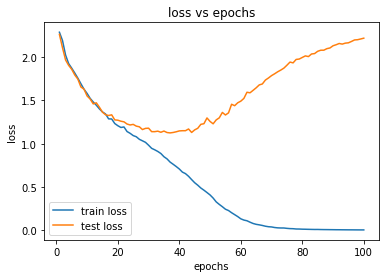

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

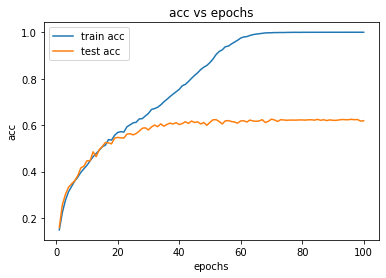

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()